# Parameterized Circuit

Note: Running this notebook requires these additional dependencies: `tensorflow`, `matplotlib`

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

from braandket import ArrayLike, tensorflow_backend
from braandket_circuit import BnkRuntime, DM, H, QOperation, QParticle, Ry, Rz, allocate_qubit

We can define a parameterized circuit as below. Theoretically `Uzyz` have the ability to fit any single qubit unitary gate.

In [2]:
class Uzyz(QOperation):
    def __init__(self, thetas: ArrayLike):
        super().__init__()
        self.thetas = thetas

    def __call__(self, qubit: QParticle):
        Rz(self.thetas[0])(qubit)
        Ry(self.thetas[1])(qubit)
        Rz(self.thetas[2])(qubit)

Suppose we want to fit Hadamard gate with `Uzyz`. 

We can define a `circuit`, in which apply an `H` gate and then an `Uzyz` and then measure a qubit.

If `Uzyz` fit `H` gate very well, the measure result probability will be `0` as the initial state.

Here we use `DM(0)` instead of `M` as the measurement, to "designate" the measurement result (of cause, this can be done only on a simulator). That way we can conveniently get the probability of getting `0`.

In [3]:
def circuit(thetas: ArrayLike, qubit: QParticle):
    H(qubit)
    Uzyz(thetas)(qubit)
    return DM(0)(qubit)

Let's try running the `circuit` with arbitrarily filled `thetas`.

In [4]:
qubit = allocate_qubit()
result = circuit([0.1, 0.2, 0.3], qubit)

print(f"{result.value=}")
print(f"{result.prob=}")

result.value=0
result.prob=array(0.40116159)


Then we want to optimize the `thetas` so that the `Uzyz` fits `H` better. Here we use gradient descent as the optimization method, and we obtain the gradient with the help of TensorFlow.

By default, this framework use numpy to perform the computation. To use tensorflow, we need to run the circuit within a "tensorflow-backend runtime". Correspondingly, the arguments (`thetas`) and returned values (`result.value` and `result.prob`) should all be `tf.Tensor`.

In this case, we use `BnkRuntime(tensorflow_backend)` as the runtime. We can use `with` to conveniently switch the runtime. Note that the calling of `allocate_qubit` also needs to be wrapped inside because it involves the initialization of quantum state.

In [5]:
thetas = tf.Variable(tf.zeros(3, dtype=tf.float32))

with BnkRuntime(tensorflow_backend):
    qubit = allocate_qubit()
    result = circuit(thetas, qubit)

print(f"{result.value=}")
print(f"{result.prob=}")

result.value=<tf.Tensor: shape=(), dtype=int32, numpy=0>
result.prob=<tf.Tensor: shape=(), dtype=float64, numpy=0.4999999999999999>


To obtain the gradient with the help of TensorFlow, we use the `tf.GradientTape` (the officially recommended way).

In [6]:
thetas = tf.Variable(tf.zeros(3, dtype=tf.float32))

with BnkRuntime(tensorflow_backend), tf.GradientTape() as tape:
    qubit = allocate_qubit()
    result = circuit(thetas, qubit)

gradients = tape.gradient(result.prob, thetas)
print(f"{gradients=}")

gradients=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0. , -0.5,  0. ], dtype=float32)>


We can use many utils in tensorflow to do the optimization. 

In this case, we use:
* `tf.keras.optimizers.Adam` as the optimizer.
* `tf.keras.losses.binary_crossentropy` as the loss function.
* `tf.function` to optimize the forward and backward process.

i=0, prob=0.50, loss=0.6931
i=1, prob=0.51, loss=0.6733
i=2, prob=0.52, loss=0.6539
i=3, prob=0.53, loss=0.6350
i=4, prob=0.54, loss=0.6164
i=5, prob=0.55, loss=0.5982
i=6, prob=0.56, loss=0.5804
i=7, prob=0.57, loss=0.5630
i=8, prob=0.58, loss=0.5459
i=9, prob=0.59, loss=0.5293
i=10, prob=0.60, loss=0.5131
i=11, prob=0.61, loss=0.4972
i=12, prob=0.62, loss=0.4818
i=13, prob=0.63, loss=0.4667
i=14, prob=0.64, loss=0.4519
i=15, prob=0.65, loss=0.4376
i=16, prob=0.65, loss=0.4236
i=17, prob=0.66, loss=0.4099
i=18, prob=0.67, loss=0.3967
i=19, prob=0.68, loss=0.3837
i=20, prob=0.69, loss=0.3711
i=21, prob=0.70, loss=0.3589
i=22, prob=0.71, loss=0.3469
i=23, prob=0.72, loss=0.3353
i=24, prob=0.72, loss=0.3240
i=25, prob=0.73, loss=0.3131
i=26, prob=0.74, loss=0.3024
i=27, prob=0.75, loss=0.2921
i=28, prob=0.75, loss=0.2820
i=29, prob=0.76, loss=0.2722
i=30, prob=0.77, loss=0.2627
i=31, prob=0.78, loss=0.2535
i=32, prob=0.78, loss=0.2446
i=33, prob=0.79, loss=0.2359
i=34, prob=0.80, loss=0.

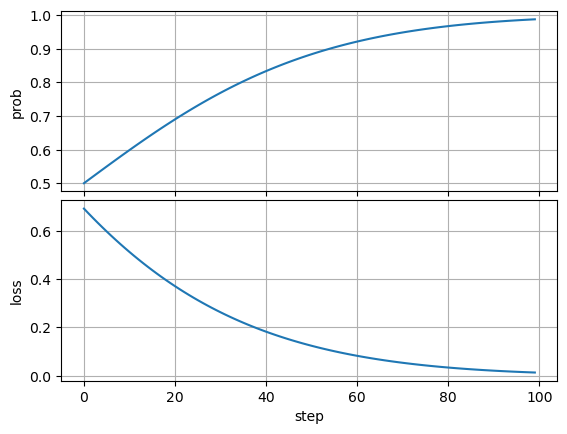

In [7]:
thetas = tf.Variable(tf.zeros(3, dtype=tf.float32))
optimizer = tf.keras.optimizers.Adam(2e-2)


@tf.function
def forward_and_backward():
    with BnkRuntime(tensorflow_backend), tf.GradientTape() as tape:
        qubit = allocate_qubit()
        result = circuit(thetas, qubit)
        loss = tf.keras.losses.binary_crossentropy([1.0], [result.prob])

    gradients = tape.gradient(loss, thetas)
    optimizer.apply_gradients(zip([gradients], [thetas]))

    return result.prob, loss


logs_prob = []
logs_loss = []
for i in range(100):
    prob, loss = forward_and_backward()

    print(f"{i=}, prob={float(prob):.2f}, loss={float(loss):.4f}")
    logs_prob.append(float(prob))
    logs_loss.append(float(loss))

fig, (axes0, axes1) = plt.subplots(2, 1, sharex='all')
fig.subplots_adjust(hspace=0.05)
axes0.plot(logs_prob)
axes0.set_ylabel('prob')
axes0.grid('all')
axes1.plot(logs_loss)
axes1.grid('all')
axes1.set_ylabel('loss')
axes1.set_xlabel('step')
plt.show()